In [19]:
import numpy as np
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from itertools import zip_longest
from itertools import combinations
from IPython.display import HTML
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from termcolor import colored
from scipy import spatial


# Set up the board:

In [2]:
our_team = ["moon", "card", "eye", "berry", "battery", "embassy", "bridge", "cycle", "water"]
their_team = ['dice', 'change', 'spell', 'moscow', 'rose', 'penguin', 'microscope', 'bell']
bomb = ['giant']
neutral = ['phoenix', 'police', 'tag', 'film', 'doctor', 'mercury', 'beat']

In [3]:
labels = ['our_team']*len(our_team) + ['their_team']*len(their_team) + ['bomb'] + ['neutral']*len(neutral)
words = our_team + their_team + bomb + neutral


In [4]:
color_map = {'our_team': 'deeppink', 'their_team':'cornflowerblue', 'bomb':'yellow', 'neutral':'grey'}

# Load the pretrained word embeddings

In [38]:
embeddings = {}
with open("./top_50000.txt", 'r') as f:
    for line in f:
        word_info = line.split()
        word = word_info[0]
        embeddings[word] = np.asarray(word_info[1:], "float32")
        
        

In [32]:
def distance(word, reference):
    return spatial.distance.cosine(embeddings[word], embeddings[reference])

def find_closest_embeddings(embed):
    return sorted(embeddings.keys(), key=lambda word: spatial.distance.cosine(embeddings[word], embed))


In [33]:
'king: ' + ', '.join(w for w in find_closest_embeddings(embeddings['king'])[:20])


'king: king, queen, prince, kings, henry, kingdom, reign, throne, george, lord, emperor, charles, son, john, duke, david, solomon, father, ii, edward'

In [ ]:
# Just with these embeddings, you can do math. For instance, 

# find_closest_embeddings(embeddings['king'] - embeddings['man'] + embeddings['woman'])




## Reduce dimensions to visualize codenames board


In [10]:
def TSNE_fit(embedding_matrix, n_comp = 2):
    return TSNE(n_components=n_comp, init='random', perplexity=5).fit_transform(embedding_matrix)
    

In [11]:
def PCA_fit(embedding_matrix, n_comp=2):
    return PCA(n_components = n_comp).fit_transform(embedding_matrix)
    

In [12]:
def matrix_to_df(X_embedded, words, labels):
    temp_dict = {}
    temp_list = []
    
    
    for i, row in enumerate(X_embedded):
        temp_dict = {}
        temp_dict['word'] = words[i]
        temp_dict['label'] = labels[i]
        temp_dict['dim1'] = row[0]
        temp_dict['dim2'] = row[1]
        if len(row) == 3:
            temp_dict['dim3'] = row[2]
        temp_list.append(temp_dict)
        
    return pd.DataFrame(temp_list)



In [50]:
def plot_3d(df_reduced, color_map):
    fig = px.scatter_3d(df_reduced, x = 'dim1', y = 'dim2', z = 'dim3', color = 'label', text = 'word', hover_name = 'word', 
    color_discrete_map= color_map)
    fig.show()

In [43]:
def plot_2d(df_reduced, color_map):
    fig = px.scatter(df_reduced, x = 'dim1', y = 'dim2', color = 'label', text = 'word', hover_name = 'word', 
           color_discrete_map= color_map)
    fig.show()

In [ ]:
embedding_matrix = [embeddings[key] for key in words]
embedding_matrix = np.array(embedding_matrix)

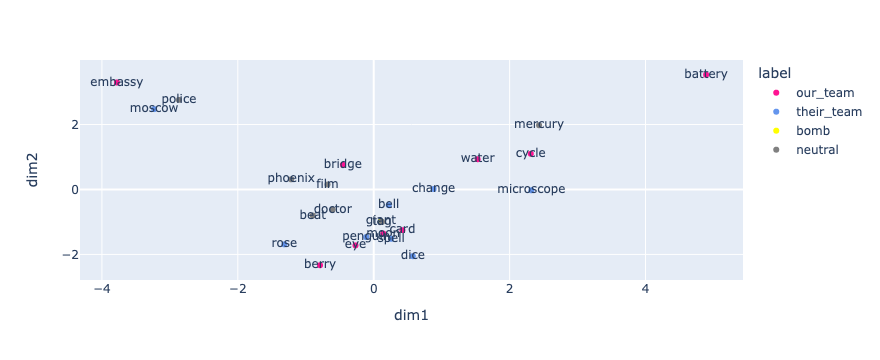

In [85]:
X_embedded = PCA_fit(embedding_matrix, n_comp = 2)
df_reduced = matrix_to_df(X_embedded, words, labels)
plot_2d(df_reduced, color_map)


## Plot the board in 3D space

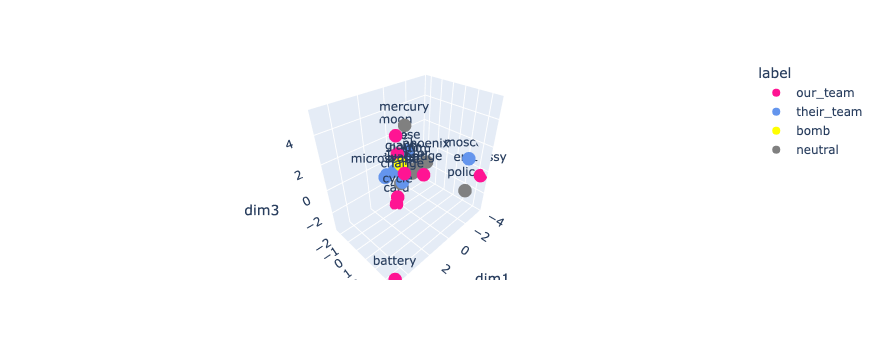

In [86]:
X_embedded = PCA_fit(embedding_matrix, n_comp = 3)
df_reduced = matrix_to_df(X_embedded, words, labels)
plot_3d(df_reduced, color_map)

In [54]:
def word_list_str(group):
    return(', '.join(w for w in group))

print(colored('OUR TEAM: \n' + word_list_str(our_team), 'red'))
print(colored('THEIR TEAM: \n' + word_list_str(their_team), 'blue'))
print(colored('BOMB: \n' + word_list_str(bomb), 'yellow'))
print(colored('NEUTRAL: \n' + word_list_str(neutral), 'grey'))



OUR TEAM: 
moon, card, eye, berry, battery, embassy, bridge, cycle, water
THEIR TEAM: 
dice, change, spell, moscow, rose, penguin, microscope, bell
BOMB: 
giant
NEUTRAL: 
phoenix, police, tag, film, doctor, mercury, beat


# Once words are decided, find best clue

In [55]:
################### MAKE A CHOICE OF WHICH OF YOUR WORDS TO CLUE

sub_list_our_words = ['cycle', 'water', 'bridge']
others = their_team + bomb + neutral

In [ ]:
# Algorithm from https://jsomers.net/glove-codenames/, pick words 
# that maximize distance to other words and minimize distance to our words

In [63]:
multiplier = 4.0

def goodness(word, answers, bad):
    if word in answers + bad: return -999
    return sum([distance(word, b) for b in bad]) - multiplier * sum([distance(word, a) for a in answers])

def minimax(word, answers, bad):
    if word in answers + bad: return -999
    return min([distance(word, b) for b in bad]) - max([distance(word, a) for a in answers])

def candidates(answers, bad, size=100):
    best = sorted(embeddings.keys(), key=lambda w: -1 * goodness(w, answers, bad))
    res = [(str(i + 1), "{0:.2f}".format(minimax(w, answers, bad)), w) for i, w in enumerate(sorted(best[:250], key=lambda w: -1 * minimax(w, answers, bad))[:size])]
    return [(". ".join([c[0], c[2]]) + " (" + c[1] + ")") for c in res]

In [64]:
temp = candidates(sub_list_our_words, others, size=100)

# Plot the chosen word in the board space

In [68]:
potential_clues_list = temp[:10]

In [74]:
clue_words = [potential_clues_list[i].split(' ')[1] for i, r in enumerate(potential_clues_list)]
clue_matrix = [embeddings[word] for word in clue_words]
embedding_matrix_with_clue = np.vstack((embedding_matrix, clue_matrix))
words_b = words + clue_words

labels_b = labels + ['clue']* len(clue_words)
color_map['clue'] = 'lightgreen'

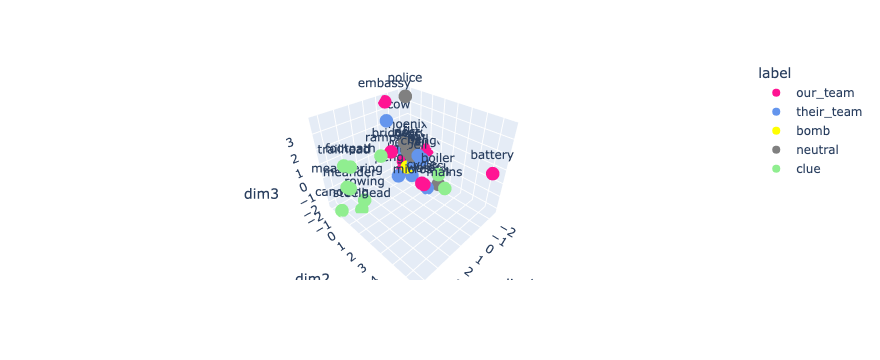

In [75]:
X_embedded = PCA_fit(embedding_matrix_with_clue, n_comp = 3)
df_reduced = matrix_to_df(X_embedded, words_b, labels_b)
plot_3d(df_reduced, color_map)